# Fushion of IMU and Audio features
## Without doing time shifting
## Training on Synchronized Audio and IMU data

## IMU and Audio data is concatenated at an intermediate layer and then prediction is made

In [1]:
import numpy as np
import scipy.io

from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint


import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

from matplotlib import pyplot as plt
from PIL import Image as img_PIL


# random seed.
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10


    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet/auto_data/'


def get_train_data(path=path):
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=np.asarray(Train_data['arr_0'],dtype=np.float64)
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_valid_data(path=path):
    Train_data=np.load(path+'valid_1000.npz')
    Features_imu=np.asarray(Train_data['arr_0'],dtype=np.float64)
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_test_data(path=path):
    Train_data=np.load(path+'test_1377.npz')
    Features_imu=np.asarray(Train_data['arr_0'],dtype=np.float64)
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound


In [4]:
Features_imu,Labels,Features_sound = get_train_data()
print(Features_imu.shape, Labels.shape, Features_sound.shape)
print('Train Classes distribution: ',np.sum(Labels, axis =0))

Features_imu2,Labels2,Features_sound2 = get_valid_data()
print(Features_imu2.shape, Labels2.shape, Features_sound2.shape)
print('Valid Classes distribution: ',np.sum(Labels2, axis =0))

Features_imu3,Labels3,Features_sound3 = get_test_data()
print(Features_imu3.shape, Labels3.shape, Features_sound3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis =0))

(5000, 1, 40, 12) (5000, 7) (5000, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 656.]
(1000, 1, 40, 12) (1000, 7) (1000, 193)
Valid Classes distribution:  [150. 188. 136. 141.  98. 157. 130.]
(1377, 1, 40, 12) (1377, 7) (1377, 193)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


In [5]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet/Baseline_IMU_Audio_Fusion'

# Combined Model: Audio + IMU

In [6]:
input_audio = keras.layers.Input(shape=(193,))
A1 = keras.layers.Dense(256, activation='relu')(input_audio)
A2 = keras.layers.Dense(256, activation='relu')(A1)
D1 = keras.layers.Dropout(0.3)(A2)
A5 = keras.layers.Dense(128, activation='relu')(D1)



num_feat_map=32
_, dim, win_len, _, = Features_imu.shape
input_imu = keras.layers.Input(shape=(dim, win_len, 12))

I1 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 padding='same')(input_imu)
I2=keras.layers.MaxPooling2D(pool_size=(1, 2))(I1)

I3 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 padding='same')(I2)
I4=keras.layers.MaxPooling2D(pool_size=(1, 2))(I3)
I5=keras.layers.Flatten()(I4)

I6= keras.layers.Dense(256, activation='relu')(I5)
D2 = keras.layers.Dropout(0.3)(I6)

I7= keras.layers.Dense(128, activation='relu')(D2)


# equivalent to added = keras.layers.add([x1, x2])
C1 =keras.layers.concatenate([A5, I7], axis=-1)


C3= keras.layers.Dense(64, activation='relu')(C1)

out = keras.layers.Dense(7, activation='softmax')(C3)

model = keras.models.Model(inputs=[input_audio, input_imu], outputs=out)


In [7]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 40, 12)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1, 40, 32)    1952        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 1, 20, 32)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 20, 32)    5152        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [8]:



from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_accuracy' ,save_best_only=True, save_weights_only=False)

In [9]:
Features_sound2.shape

(1000, 193)

In [10]:
batch_size = 128
epochs = 100
from keras import optimizers
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = model.fit([Features_sound,Features_imu], Labels,
                    verbose=0,
                    epochs=epochs,
                        shuffle=True,
                    batch_size=batch_size,
                        callbacks=[checkpointer,TqdmCallback(verbose=2)],
                    validation_data=([Features_sound2,Features_imu2], Labels2)
                         
                         )

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00001: val_accuracy improved from -inf to 0.69400, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00002: val_accuracy improved from 0.69400 to 0.78200, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00003: val_accuracy improved from 0.78200 to 0.89000, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00004: val_accuracy improved from 0.89000 to 0.91900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00005: val_accuracy improved from 0.91900 to 0.92400, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00006: val_accuracy improved from 0.92400 to 0.93000, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00007: val_accuracy improved from 0.93000 to 0.94200, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00008: val_accuracy improved from 0.94200 to 0.94800, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00009: val_accuracy improved from 0.94800 to 0.94900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00010: val_accuracy improved from 0.94900 to 0.95100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00011: val_accuracy improved from 0.95100 to 0.95900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00012: val_accuracy did not improve from 0.95900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00013: val_accuracy did not improve from 0.95900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00014: val_accuracy improved from 0.95900 to 0.96100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00015: val_accuracy improved from 0.96100 to 0.97100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00016: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00017: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00018: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00019: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00020: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00021: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00022: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00023: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00024: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00025: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00026: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00027: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00028: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00029: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00030: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00031: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00032: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00033: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00034: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00035: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00036: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00037: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00038: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00039: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00040: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00041: val_accuracy did not improve from 0.97100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00042: val_accuracy improved from 0.97100 to 0.97800, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00043: val_accuracy did not improve from 0.97800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00044: val_accuracy did not improve from 0.97800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00045: val_accuracy did not improve from 0.97800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00046: val_accuracy improved from 0.97800 to 0.97900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00047: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00048: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00049: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00050: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00051: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00052: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00053: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00054: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00055: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00056: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00057: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00058: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00059: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00060: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00061: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00062: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00063: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00064: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00065: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00066: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00067: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00068: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00069: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00070: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00071: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00072: val_accuracy did not improve from 0.97900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00073: val_accuracy improved from 0.97900 to 0.98100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\Baseline_IMU_Audio_Fusion\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00074: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00075: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00076: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00077: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00078: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00079: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00080: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00081: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00082: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00083: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00084: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00085: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00086: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00087: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00088: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00089: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00090: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00091: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00092: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00093: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00094: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00095: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00096: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00097: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00098: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00099: val_accuracy did not improve from 0.98100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00100: val_accuracy did not improve from 0.98100
---Time 43.84847450256348 seconds ---


# Accuracies

In [11]:
from keras.models import load_model

model = load_model(model_path)

In [12]:
#Train Accuracy
model.evaluate([Features_sound,Features_imu],Labels)

157/157 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000


[0.0012484996113926172, 1.0]

In [13]:
## Valid Accuracy
model.evaluate([Features_sound2,Features_imu2],Labels2)

32/32 [==============================] - 0s 2ms/step - loss: 0.1188 - accuracy: 0.9810


[0.11882619559764862, 0.9810000061988831]

In [14]:
## Test Accuracy
model.evaluate([Features_sound3,Features_imu3],Labels3)

44/44 [==============================] - 0s 2ms/step - loss: 0.1293 - accuracy: 0.9651


[0.1292518526315689, 0.9651415944099426]

# Plotting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


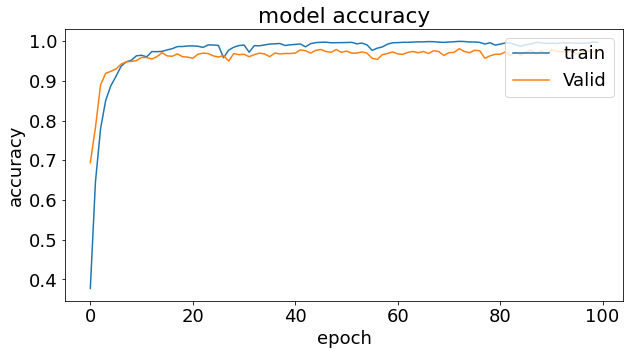

In [15]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

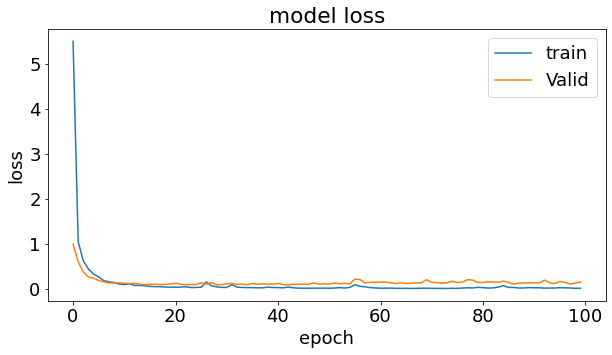

In [16]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()